In [1]:
import pandas as pd
import math
import numpy as np
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
import matplotlib.pyplot as plt
from scipy import stats
from scipy import cluster

In [2]:
n = 1000
beta01, beta11 = 5,-3
beta02, beta12 = 2, 4

#set up regression mixture
x1 = np.random.uniform(0, 10, size=400)
x2 = np.random.uniform(0, 10, size=600)

y1 = beta01 + beta11*x1 + np.random.normal(scale=5.0, size=400)
y2 = beta02 + beta12*x2 + np.random.normal(scale=4.0,size=600)

X = np.concatenate([x1, x2])
Y = np.concatenate([y1, y2])


#set up 2 component mixture
a1 = np.random.normal(2, 5, size=600)
a2 = np.random.normal(5, 3, size=400)
a = np.concatenate([a1,a2])

In [24]:
def e_step(y,x,params): 
    y, x = np.array(y), np.array(x)
    nobs, k = x.shape
    weights = []
    for param in params:

        sigma = param[-1]
        beta = np.tile(param[1:-1],nobs).reshape(nobs, k)
        mean = (beta*x).sum(axis=1)
        weights.append( stats.norm.pdf(y, loc=mean, scale=sigma)*param[0] )

    #update loop variables
    weights = np.array(weights).transpose()
    #denom = np.repeat( 1+np.exp(weights).sum(axis=1), len(params) ).reshape(nobs,len(params))
    denom = np.repeat(weights.sum(axis=1), len(params) ).reshape(nobs,len(params))
    weights = weights/denom
    return weights
        
    
def m_step(y,x,weights):
    y, x, weights = np.array(y), np.array(x), np.array(weights)
    nobs, k = x.shape
    params, se, err = [], [], 0

    for w in weights.transpose():
        
        lamb = w.mean()
        lamb_se = w.std()

        #beta
        w_mat = np.diag(w)
        xx_mat = np.linalg.inv( x.transpose().dot( w_mat).dot(x) )
        beta = xx_mat.dot(x.transpose().dot(w_mat)).dot(y)
        
        #sigma
        mu = np.tile(beta, nobs).reshape(nobs, k)*x
        weighted_err = w*(y - mu.sum(axis=1))**2
        sigma =  (weighted_err.sum()/w.sum())**.5

        #add component
        comp_param =np.concatenate(([lamb],beta,[sigma]))
        params.append(comp_param)

        #beta_se
        beta_se = (np.diagonal(xx_mat*sigma**2))**.5
        comp_se = np.concatenate(([lamb_se],beta_se))
        se.append(comp_se)

        #SSR
        err = err+weighted_err
    return np.array(params), np.array(se), 1-err.mean()/y.var()


def gen_weights(y,ncomp):
    c,labels = cluster.vq.kmeans2(y,ncomp)
    return np.array(pd.get_dummies(labels))


def estimate(y,x,ncomp):
    e = gen_weights(y,ncomp)
    m = None
    for i in range(15):
        m,se,r2 = m_step(y,x,e)
        e = e_step(y,x,m)
    return m, se, r2, y, x, ncomp


m, se, r2, y, x, ncomp = estimate(Y, sm.add_constant(X), 2)
print m

[[ 0.3902011   4.76418441 -2.98527709  5.13273322]
 [ 0.6097989   1.30088735  4.13835377  3.78403324]]


In [25]:
def write_table(fname, estimates, labels=('y',None)):
    
    #unpack relevant information
    params, se, r2, y, x, ncomp = estimates
    nobs, k = x.shape
    ylabel, xlabel = labels
    
    if xlabel == None:
        xlabel =[]
        for i in range(k):
            xlabel.append('x%s'%i)
            
    assert (k == len(xlabel)) 
    
    f = open(fname, "w+")
    
    f.write(('\\begin{center}  \n'+
            '\\begin{tabular}{lclc} \n'+
            '\\toprule \n'+
            '\\textbf{Dep. Variable:} & %s & \\textbf{  R-squared: } &  %s \\\\ \n'%(ylabel, np.round(r2,3))  ))
    
    f.write(('\\textbf{No. Observations:} & %s & & \\\\ \n'%nobs+
            '\end{tabular} \n'))
    
    
    f.write('\n\\begin{tabular}{lcccc} \n')
    for comp in range(ncomp):
        f.write('\\toprule \n')
        f.write('\\textbf{Regime %s} & \\textbf{est} & \\textbf{std err} &'%(1+comp)+ 
                '\\textbf{t} & \\textbf{P $>$ $|$ t $|$} \\\\ \n')
        f.write('\\bottomrule \\\\ \n')
        
        #isolate params
        comp_params = params[comp]
        comp_se = se[comp]
        comp_t = comp_params[:-1]/comp_se
        comp_p = 1 - stats.t.cdf(np.abs(comp_t),df=(nobs-k)) + stats.t.cdf(-np.abs(comp_t),df=(nobs-k))
        
        #round everything
        comp_params = np.round(comp_params,5)
        comp_se = np.round(comp_se,5)
        comp_t = np.round(comp_t,5)
        comp_p = np.round(comp_p,5)
        
        lamb, lamb_se, lamb_t, lamb_p = comp_params[0], comp_se[0], comp_t[0], comp_p[0]
        beta, beta_se, beta_t, beta_p = comp_params[1:-1], comp_se[1:], comp_t[1:], comp_p[1:]
        sigma = comp_params[-1]
        
        
        f.write('\\textbf{lambda} & %s & (%s) & %s & %s \\\\ \\\\ \n'%(lamb,lamb_se,lamb_t,lamb_p) )
        
        for i in range(k):
            f.write('\\textbf{%s} & %s & (%s) & %s & %s \\\\ \\\\ \n'%(xlabel[i],beta[i],beta_se[i],
                                                                             beta_t[i],beta_p[i]) )
        
        f.write('\\textbf{sigma} & %s &  & & \\\\ \\\\ \n'%(sigma) )
    
    f.write('\end{tabular} \n'+
            '\end{center}\n')
    f.close()
    
    #print output
    f = open(fname, "r")
    print f.read()
    f.close()

(4004,)


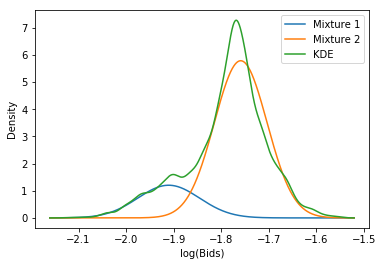

In [26]:
data = pd.read_csv('data/milk.csv')

bids = np.array(data['WW'].dropna())
lbids = np.log(bids[ (bids >= .12) &(bids<=.21)])

print lbids.shape

#do KDE
dens = sm.nonparametric.KDEUnivariate(lbids)
dens.fit()

# do Guasian mixture
est = estimate(lbids,np.ones((len(lbids),1)) , 2)
coefs = est[0]
comp1 = coefs[0,0]*stats.norm.pdf(dens.support,coefs[0,1],coefs[0,2])
comp2 = coefs[1,0]*stats.norm.pdf(dens.support,coefs[1,1],coefs[1,2])


plt.plot(dens.support, comp1, label='Mixture 1')
plt.plot(dens.support, comp2, label='Mixture 2')
plt.xlabel('log(Bids)')
plt.ylabel('Density')
plt.plot(dens.support, dens.density, label='KDE')
plt.legend()
plt.savefig('results/bid_mixture.png')
plt.show()

In [39]:
data = pd.read_csv('data/milk.csv')

reg1['COOLER'] = reg1['COOLER'].fillna(0)
reg1 = data[['WW','ESC','FMO','GAS','POPUL','DEL','NUMSCHL','COOLER']].dropna()
reg1 = sm.add_constant(reg1)

reg1['QSTOP'] = reg1['POPUL']/(reg1['DEL']*reg1['NUMSCHL'])
reg1['NOSTOP'] = reg1['DEL']*reg1['NUMSCHL']

reg1[['WW','FMO','GAS','QSTOP']] = np.log(reg1[['WW','FMO','GAS','QSTOP']])

est1 = estimate(reg1['WW'],reg1[['const','FMO','GAS','QSTOP']],1)
write_table('results/ols_results.tex', est1, labels=('WW', ['const','ESC','FMO','GAS']))

\begin{center}  
\begin{tabular}{lclc} 
\toprule 
\textbf{Dep. Variable:} & WW & \textbf{  R-squared: } &  0.027 \\ 
\textbf{No. Observations:} & 1659 & & \\ 
\end{tabular} 

\begin{tabular}{lcccc} 
\toprule 
\textbf{Regime 1} & \textbf{est} & \textbf{std err} &\textbf{t} & \textbf{P $>$ $|$ t $|$} \\ 
\bottomrule \\ 
\textbf{lambda} & 1.0 & (0.0) & inf & 0.0 \\ \\ 
\textbf{const} & -2.35247 & (0.08884) & -26.47867 & 0.0 \\ \\ 
\textbf{ESC} & 0.18414 & (0.0319) & 5.77297 & 0.0 \\ \\ 
\textbf{FMO} & 0.00648 & (0.00527) & 1.22948 & 0.21907 \\ \\ 
\textbf{GAS} & 0.01433 & (0.00403) & 3.55972 & 0.00038 \\ \\ 
\textbf{sigma} & 0.06852 &  & & \\ \\ 
\end{tabular} 
\end{center}



/home/erichschulman/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in divide


In [40]:
est1 = estimate(reg1['WW'],reg1[['const','FMO','GAS','QSTOP']],2)
write_table('results/prelim_results.tex', est1, labels=('WW', ['const','ESC','FMO','GAS']))

\begin{center}  
\begin{tabular}{lclc} 
\toprule 
\textbf{Dep. Variable:} & WW & \textbf{  R-squared: } &  0.109 \\ 
\textbf{No. Observations:} & 1659 & & \\ 
\end{tabular} 

\begin{tabular}{lcccc} 
\toprule 
\textbf{Regime 1} & \textbf{est} & \textbf{std err} &\textbf{t} & \textbf{P $>$ $|$ t $|$} \\ 
\bottomrule \\ 
\textbf{lambda} & 0.24995 & (0.24567) & 1.01742 & 0.3091 \\ \\ 
\textbf{const} & -2.71951 & (0.25037) & -10.86214 & 0.0 \\ \\ 
\textbf{ESC} & 0.19126 & (0.08721) & 2.19314 & 0.02844 \\ \\ 
\textbf{FMO} & 0.06726 & (0.01751) & 3.84115 & 0.00013 \\ \\ 
\textbf{GAS} & 0.04373 & (0.01332) & 3.28338 & 0.00105 \\ \\ 
\textbf{sigma} & 0.10628 &  & & \\ \\ 
\toprule 
\textbf{Regime 2} & \textbf{est} & \textbf{std err} &\textbf{t} & \textbf{P $>$ $|$ t $|$} \\ 
\bottomrule \\ 
\textbf{lambda} & 0.75005 & (0.24567) & 3.05309 & 0.0023 \\ \\ 
\textbf{const} & -2.33303 & (0.06952) & -33.56106 & 0.0 \\ \\ 
\textbf{ESC} & 0.21584 & (0.0252) & 8.56556 & 0.0 \\ \\ 
\textbf{FMO} & -0.01053